# Code

## Standard imports

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 30

from IPython import get_ipython
ipython = get_ipython()

# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload

%autoreload 2

import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline

import time
np.random.seed(int(time.time()))

## Specific imports

In [6]:
import sys
sys.path.insert(1, '../sglv_timeseries')

import sglv_timeseries.ibm.Timeseries as ibm
import sglv_timeseries.glv.Timeseries as glv
from sglv_timeseries.noise_parameters import NOISE
from sglv_timeseries.models import MODEL
from sglv_timeseries.timeseries_plotting import PlotTimeseries

from matplotlib import colorbar as mcolorbar

import sys
sys.path.insert(1, '../helper_functions')

from piecewise_normalizations import PiecewiseLogNorm, PiecewiseNormalize

from itertools import count

from heavytails import fit_heavytail, plot_heavytail, normalizations, plot_cdf_heavytail

import warnings

#from elife_settings import ELIFE, set_elife_settings
#set_elife_settings()

from presentation_settings import PRESENTATION, set_presentation_settings
set_presentation_settings()

## Random paramaters and example plot functions

In [3]:
from scipy import stats

def random_parameter_set(S, connectance=0.3, minint=-0.5, maxint=0.5,
                         minmigration=0.4, maxmigration=0.4,
                         minextinction=0.5, maxextinction=0.5, growth_rate=1.5):
    interaction = np.random.uniform(minint, maxint, [S, S])
    interaction *= np.random.choice([0, 1], interaction.shape, p=[1 - connectance, connectance])  # connectance
    np.fill_diagonal(interaction, -1.)  # self-interaction

    growth_rate = np.full([S, 1], growth_rate)
    immigration = np.random.uniform(minmigration, maxmigration, [S, 1])
    extinction = np.random.uniform(minextinction, maxextinction, [S, 1])

    params = {'interaction_matrix': interaction, 'immigration_rate': immigration,
              'extinction_rate': extinction, 'growth_rate': growth_rate}

    return params

def random_parameter_set_ibm(S, connectance=0.3, minint=-0.5, maxint=0.5,
                         minmigration=0.4, maxmigration=0.4,
                         minextinction=0.5, maxextinction=0.5, growth_rate=1.5):
    
    interaction = np.random.uniform(minint, maxint, [S, S])
    interaction *= np.random.choice([0, 1], interaction.shape, p=[1 - connectance, connectance])  # connectance
    np.fill_diagonal(interaction, -1.)  # self-interaction

    growth_rate = np.full([S, 1], growth_rate)
    immigration = np.random.uniform(minmigration, maxmigration, [S, 1])
    extinction = np.random.uniform(minextinction, maxextinction, [S, 1])

    SIS = []
    SISfactor = 200

    SISvector = np.ones(S, dtype=int)
    SISvector[SIS] *= SISfactor

    params = {'interaction_matrix' : interaction, 'immigration_rate' : immigration, 
             'extinction_rate' : extinction,
               'growth_rate' : growth_rate, 'SIS':SIS, 'SISvector':SISvector}

    return params


def random_parameter_set_logistic(S, width_growth=1):
    growth_rate = stats.lognorm.rvs(loc=0, s=width_growth, size=[S, 1])
    if np.sqrt(4 - width_growth ** 2) == 0:
        self_int = np.ones(S)
    else:
        self_int = stats.lognorm.rvs(loc=0, s=np.sqrt(4 - width_growth ** 2), size=S)

    interaction = np.zeros([S, S])
    np.fill_diagonal(interaction, -self_int)  # self-interaction

    growth_rate = np.full([S, 1], growth_rate)
    immigration = np.zeros([S, 1])
    extinction = np.zeros([S, 1])

    params = {'interaction_matrix': interaction, 'immigration_rate': immigration,
              'extinction_rate': extinction, 'growth_rate': growth_rate}

    return params

def add_SIS(interaction, SISvector):
    interaction_SIS = interaction * SISvector
    np.fill_diagonal(interaction_SIS, np.diag(interaction))
    return interaction_SIS

def parameters_to_Zdenko_parameters(interaction, growth_rate, immigration, extinction, SISvector):
    omega_Z = np.zeros((len(interaction)+1, len(interaction)+1)); 
    omega_Z[1:,1:] = interaction; omega_Z[1:,0] = growth_rate.flatten()
    mu_Z = np.hstack(([0], immigration))
    e_Z = np.hstack(([0], extinction))
    SISvector_Z = np.hstack(([1], SISvector))
    
    return omega_Z, mu_Z, e_Z, SISvector_Z

In [4]:
from variation import variation_coefficient, JS

def example_timeseries(connectance, immigration, int_strength, noise=None, 
                       max_cap=None, sites=None, S=200, 
                       noise_implementation=NOISE.LANGEVIN_LINEAR):
    
    if sites == None:
        params = random_parameter_set(S, 
           minmigration=immigration, maxmigration=immigration, connectance=connectance,
           minint=-int_strength, maxint=int_strength)
        
        if np.isinf(max_cap):
            model = MODEL.GLV
            params['initial_condition'] = np.random.uniform(0, 1, [S,1])
        else:
            model = MODEL.MAX
            params['maximum_capacity'] = max_cap
            initcond = np.random.uniform(0, 1, [S,1])
            params['initial_condition'] = initcond*max_cap/S
        if noise_implementation == NOISE.LANGEVIN_LINEAR:
            params['noise_linear'] = noise
        elif noise_implementation == NOISE.LANGEVIN_SQRT:
            params['noise_sqrt'] = noise
        elif noise_implementation == NOISE.LANGEVIN_CONSTANT:
            params['noise_constant'] = noise
        
    elif sites != None and max_cap == None:
        params = random_parameter_set_ibm(S,
           minmigration=immigration, maxmigration=immigration, 
                                          connectance=connectance,
           minint=-int_strength, maxint=int_strength)
    
        model = MODEL.IBM
        params['initial_condition'] = np.random.randint(0, int(0.66*sites/S), S)
        params['sites'] = sites
    return show_example(params, model, noise_implementation)

def example_timeseries_logistic(width_growth, noise, S=200):
    params = random_parameter_set_logistic(S, width_growth)

    #interaction_SIS = add_SIS(interaction, SISvector)
    initcond = np.random.uniform(0, 1, [S,1])
    
    params = {'interaction_matrix' : interaction, 'immigration_rate' : immigration, 
            'extinction_rate' : extinction, 'initial_condition' : initcond, 
            'noise_linear' : noise, 'growth_rate' : growth_rate}
    
    return show_example(params, MODEL.GLV)

def show_example(params, model, noise_implementation):
    # find steady state without noise
    if model in [MODEL.GLV, MODEL.MAX]:
        params_init = params.copy()
        params_init['noise_linear'] = 0
        ts = glv.Timeseries(params_init, T = 125, dt=0.005, tskip=199, model=model)
        discrete = False
    elif model == MODEL.IBM:
        ts = ibm.Timeseries(params, T = 150)
        discrete = True
        
    stab = (np.max(np.abs((ts.timeseries.iloc[-50, 1:] - ts.timeseries.iloc[-1, 1:])/ ts.timeseries.iloc[-50, 1:])) < 0.1)
    print("Deterministic solution is stable:", stab)
    #if stab == False:
    #    print(ts.timeseries.iloc[0,:])
    #    print(ts.timeseries.iloc[1,:])
    ep = ts.endpoint
    col_to_drop = ep.index[ep.endpoint < 1e-6*np.max(ep.endpoint)]
    
    PlotTimeseries(ts.timeseries.drop(columns=col_to_drop))

    if model in [MODEL.GLV, MODEL.MAX]:
        params['initial_condition'] = ts.endpoint.values.astype('float')
        ts = glv.Timeseries(params, T = 250, dt=0.005, tskip=199, model=model, noise_implementation=noise_implementation)
    elif model == MODEL.IBM:
        params['initial_condition'] = ts.endpoint.values.astype('int').flatten()
        ts = ibm.Timeseries(params, T = 250)
    PlotTimeseries(ts.timeseries.drop(columns=col_to_drop))
    params = variation_coefficient(ts.timeseries)
    print("variation:", params[0])
    params = JS(ts.timeseries, verbose=True)
    print("JS:", params[0])
    print("pval stable (higher more stable):", params[-1])
    
    ep = ts.endpoint.values.astype('float').flatten()
    ep = ep[ep > 1e-6*np.max(ep)]
    
    print("remaining species", len(ep))
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    print("things", ep[0], ep[-1], len(ep), discrete)
    params = fit_heavytail(ep, func='lognorm', discrete=discrete)
    plot_heavytail(ep, params, func='lognorm', ax=ax, discrete=discrete)
    print("Width lognorm:", params[0], params[1], params[2])
    print("Stat lognorm:", params[-2])
    for f in ['expon', 'norm', 'powerlaw', 'pareto']:
        params = fit_heavytail(ep, func=f, discrete=discrete)
        plot_heavytail(ep, params, func=f, ax=ax, discrete=discrete)
        print("Stat %s:" % f, params[-2])
    params = fit_heavytail(ep, func='trunc_powerlaw', discrete=discrete)
    plot_heavytail(ep, params, func='trunc_powerlaw', ax=ax, discrete=discrete)
    print("Stat trunc powerlaw:", params[-2])
    print("R powerlaw (negative -> lognormal):", params[2])
    
    return ep

# Introduction

Solé et al. (2002) obtains heavy-tailed distributions with an IBM. 

Do we obtain same results with our implementation of an IBM and with gLV?

# Plotting functions

In [18]:
from triangular_colorbar import abc_to_rgba, plot_legend

default = {'glv': {'connectance': 0.3162,
                   'immigration': 0.1, 'noise': 0.3162, 'interaction': 0.3162, 'max_cap': 1e2},
           'glv_sqrt': {'connectance': 0.3162, 'immigration': 0.1, 'noise': 0.1, 'interaction': 0.3162},
           'ibm': {'connectance': 0.1, 'immigration': 0.01, 'sites': 10000, 'interaction': 0.1}}
columns = {'glv': ['connectance', 'immigration', 'noise', 'interaction', 'max_cap'],
           'glv_sqrt': ['connectance', 'immigration', 'noise', 'interaction'],
           'ibm': ['connectance', 'immigration', 'sites', 'interaction'],
           'logistic': ['width_growth', 'noise']}
labels = {'connectance': 'Connectance', 'immigration': 'Immigration',
          'interaction': 'Interaction strength', 'noise': 'Noise strength',
          'sites': 'Maximum number\n of individuals', 'max_cap': 'Maximal capacity',
          'JS_mean': 'Average JS distance',
          'variation_mean': 'Average coefficient\n of variation',
          'variationnorm_mean': 'Average coefficient\n of variation',
          'width': 'Width of lognormal\n distribution',
          'JS_stab': 'p-value time dependence\n JS distance',
          'width_growth': 'Width of the growth rates',
          'number': 'Number of species', }


def select_rows(df, x, y, params, verbose=False):
    if verbose:
        print("len df:", len(df))
    if params == None:
        params = default[model]

    df_selection = df.copy()
    for v in params:
        if x != v and y != v:
            df_selection = df_selection[df_selection[v] == params[v]]
        if verbose:
            print(v, len(df_selection))
    return df_selection


def select_columns(all_cols, model, dist, var):
    if dist == 'all':
        cols = columns[model] + \
            [col for col in all_cols if ('_pval_' in col) or ('_R_' in col)]
    elif dist == None:
        cols = columns[model] + \
            ['%s_%d' % (var, d) for d in range(1, 11)]
    else:
        cols = columns[model] + \
            ['%s_%s_%d' % (dist, var, d) for d in range(1, 11)]
        if var == 'width':
            cols += [col for col in all_cols if ('_pval_' in col)
                     or ('_R_' in col)]
    return cols


def read_df(x, y, var, dist, model, params, noise_implementation, verbose=False):
    if model == 'glv':
        if 'noise' in [x, y] and 'max_cap' in [x, y]:
            filename = 'results/scan_glv_maxcap_immi.csv'
        elif 'interaction' in [x, y] and 'connectance' in [x, y]:
            filename = 'results/scan_glv_interactions_immi.csv'
        elif 'max_cap' in [x, y] and 'connectance' in [x, y]:
            filename = 'results/scan_glv_maxcap_immi.csv'
        elif 'immigration' in [x, y] and 'connectance' in [x, y]:
            filename = 'results/scan_glv_immigration_immi.csv'
        else:
            pass

        if noise_implementation == NOISE.LANGEVIN_LINEAR:
            pass
        elif noise_implementation == NOISE.LANGEVIN_CONSTANT:
            filename = filename[:-4] + '_constant.csv'
        else:
            print('Noise implementation does not exist!')

        headers = pd.read_csv(filename, index_col=None,
                              header=0, dtype=float, na_values='NAN', nrows=0)
        cols = select_columns(headers.columns, model, dist, var)
        df = pd.read_csv(filename, index_col=None, header=0,
                         dtype=float, na_values='NAN', usecols=cols)
        
        if False: #11
            if 'interaction' in [x, y] and 'connectance' in [x, y] and noise_implementation == NOISE.LANGEVIN_LINEAR:
                df = df[np.isfinite(df.max_cap)]
                df = pd.concat([df, pd.read_csv('results/scan_glv_interactions_inf.csv',
                                                index_col=None, header=0,
                                                dtype=float, na_values='NAN', usecols=cols)])
            elif 'immigration' in [x, y] and 'connectance' in [x, y] and noise_implementation == NOISE.LANGEVIN_LINEAR:
                df = df[np.isfinite(df.max_cap)]
                df = pd.concat([df, pd.read_csv('results/scan_glv_immigration_inf.csv',
                                                index_col=None, header=0,
                                                dtype=float, na_values='NAN', usecols=cols)])

        df = select_rows(df, x, y, params, verbose)
        return df
    elif model == 'logistic':
        if noise_implementation == NOISE.LANGEVIN_LINEAR:
            filename = 'results/scan_logistic_immi.csv'
        elif noise_implementation == NOISE.LANGEVIN_CONSTANT:
            filename = 'results/scan_logistic_constant.csv'
    elif model == 'ibm':
        filename = 'results/scan_ibm.csv'  # ibm_total.csv'

    headers = pd.read_csv(filename, index_col=None, header=0,
                          dtype=float, na_values='NAN', nrows=0)
    cols = select_columns(headers.columns, model, dist, var)
    df = pd.read_csv(filename, index_col=None, header=0,
                     dtype=float, na_values='NAN', usecols=cols)
    df = select_rows(df, x, y, params, verbose)

    return df


def add_distribution_percentages(df):
    df['pow_perc'], df['log_perc'], df['norm_perc'], \
        df['pareto_perc'], df['tpow_perc'], \
        df['pows_perc'], df['linear_dist'], df['undefined_perc'] \
        = np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan

    def perc(row):
        if True:
            powrow = row[['pow_pval_%d' % d for d in range(1, 11)]].values 
            tpowrow = row[['tpow_pval_%d' % d for d in range(1, 11)]].values
            parrow = row[['pareto_pval_%d' % d for d in range(1, 11)]].values
            logrow = row[['log_pval_%d' % d for d in range(1, 11)]].values
            normrow = row[['norm_pval_%d' % d for d in range(1, 11)]].values

            row['pareto_perc'] = np.sum((parrow > normrow) & (parrow > logrow) &
                                        (parrow > powrow) & (parrow > tpowrow)
                                        & (parrow > 0.05))/len(parrow)
            row['pow_perc'] = np.sum((powrow > normrow) & (powrow > logrow) &
                                     (powrow > parrow) & (powrow > tpowrow)
                                     & (powrow > 0.05))/len(powrow)
            row['log_perc'] = np.sum((logrow > normrow) & (logrow > parrow) &
                                     (logrow > powrow) & (logrow > tpowrow)
                                     & (logrow > 0.05))/len(logrow)
            row['norm_perc'] = np.sum((normrow > logrow) & (normrow > parrow) &
                                      (normrow > powrow) & (normrow > tpowrow)
                                      & (normrow > 0.05))/len(normrow)
            row['tpow_perc'] = np.sum((tpowrow > normrow) & (tpowrow > logrow) &
                                      (tpowrow > parrow) & (tpowrow > powrow)
                                      & (tpowrow > 0.05))/len(tpowrow)
            row['pows_perc'] = row['pareto_perc'] + \
                row['pow_perc'] + row['tpow_perc']
            row['undefined_perc'] = np.sum((normrow < 0.05) & (logrow < 0.05) &
                                           (powrow < 0.05) & (tpowrow < 0.05) & (parrow < 0.05))

            # if row['norm_perc'] != 0 and row['log_perc'] != 0 and row['pows_perc'] != 0:
            #    print('cannot convert to linear scale (norm, log, pows)', row['norm_perc'], row['log_perc'], row['pows_perc'])

            row['linear_dist'] = 0.5 * \
                (1 - row['norm_perc']) + 0.5*row['pows_perc']
        elif np.any(['_R_' in col for col in df.columns]):
            powrow = row[['tpow_R_%d' % d for d in range(1, 11)]].values 
            logrow = row[['log_pval_%d' % d for d in range(1, 11)]].values 
            normrow = row[['norm_pval_%d' % d for d in range(1, 11)]].values 

            row['pows_perc'] = np.sum(powrow > 0)/len(powrow)
            row['log_perc'] = np.sum((logrow > normrow) & (
                powrow < 0) & (logrow > 0.05))/len(logrow)
            row['norm_perc'] = np.sum((normrow > logrow) & (
                powrow < 0) & (normrow > 0.05))/len(normrow)
            row['pareto_perc'] = 0
            row['tpow_perc'] = 0
            row['undefined_perc'] = 0
        else:
            powrow = row[['pow_pval_%d' % d for d in range(1, 11)]].values 
            logrow = row[['log_pval_%d' % d for d in range(1, 11)]].values 
            normrow = row[['norm_pval_%d' % d for d in range(1, 11)]].values 

            row['pow_perc'] = np.sum((powrow > normrow) & (
                powrow > logrow) & (powrow > 0.05))/len(powrow)
            row['log_perc'] = np.sum((logrow > normrow) & (
                logrow > powrow) & (logrow > 0.05))/len(logrow)
            row['norm_perc'] = np.sum((normrow > logrow) & (
                normrow > powrow) & (normrow > 0.05))/len(normrow)
        return row

    df = df.apply(perc, axis=1)

In [10]:
def comparison_matrix(x='connectance', y='immigration', var='pval', dist='log', 
                      agg='median', ax=None, ax_cbar=None, model='glv', params=None, 
                      noise_implementation=NOISE.LANGEVIN_LINEAR, verbose=False):
    df = read_df(x, y, var, dist, model, params, noise_implementation, verbose)
    
    if ax == None:
        fig = plt.figure()
        gs = gridspec.GridSpec(1,2,width_ratios=[3,1] if dist == 'all' else [15,1])
        ax = fig.add_subplot(gs[0])
        ax_cbar = fig.add_subplot(gs[1], aspect='equal' if dist == 'all' else 'auto')
    
    norm = normalizations[var]
    if norm == None:
        norm = lambda x : x
    cmap = plt.cm.seismic
    
    # set background to grey
    ax.set_facecolor((0.8, 0.8, 0.8))
    
    if dist == 'all':
        add_distribution_percentages(df)
        
        #print("pareto", np.sum(df.pareto_perc), "powerlaw", np.sum(df.pow_perc), 
        #      "truncated powerlaw", np.sum(df.tpow_perc), "norm", np.sum(df.norm_perc), 
        #      "log", np.sum(df.log_perc), "undefined", np.sum(df.undefined_perc))
        
        df['dist_color'] = df.apply(lambda row: abc_to_rgba(
            row['log_perc'], row['pows_perc'], row['norm_perc']), axis=1)
        
        mat = df.pivot_table(values='dist_color', index=y, columns=x, dropna=False, aggfunc='first')
        # no aggregation
        assert np.product(mat.shape) == df.shape[0]
        
        im = ax.imshow( np.array([[np.array(i, dtype=float) for i in j] for j in mat.to_numpy()],
        dtype=float,), aspect='auto', origin='lower')
    else:
        df['agg'] = df[[('%s_%s_%d' % (dist, var, d) if dist != None
                         else '%s_%d' % (var,d))
                         for d in range(1,11)]].agg(agg, axis="columns").astype(float) 
        df['nonan'] = 1. - 1./10.* df[[('%s_%s_%d' % (dist, var, d) if dist != None 
                         else '%s_%d' % (var,d))
                         for d in range(1,11)]].isna().sum(axis="columns") 
        
        mat = df.pivot_table(values='agg', index=y, columns=x, dropna=False)

        if var == 'width':
            add_distribution_percentages(df)
            mat_alpha = df.pivot_table(values='log_perc', index=y, columns=x, dropna=False)
        else:
            mat_alpha = df.pivot_table(values='nonan', index=y, columns=x, dropna=False)
            #np.ones_like(mat)
            
        # no aggregation
        #assert np.product(mat.shape) == df.shape[0]
        #assert mat.shape == mat_alpha.shape
        
        colors = cmap(norm(mat.to_numpy()))
        colors[:,:,-1] = mat_alpha
        
        im = ax.imshow(colors, aspect='auto', origin='lower')
            
    ax.set_xticks(range(0, len(mat.columns), 1))
    ax.set_yticks(range(0, len(mat.index), 1))
    
    xlabels = ['INF' if np.isinf(i) else '%d' % i if int(i) == i else '%.1f' % i 
               if round(i, 1) == i else '%.2f' % i 
               if round(i, 2) == i else '%.2E' % i for i in mat.columns]
    ylabels = ['INF' if np.isinf(i) else '%d' % i if int(i) == i else '%.1f' % i 
               if round(i, 1) == i else '%.2f' % i 
               if round(i, 2) == i else '%.2E' % i for i in mat.index]
    
    ax.set_xticklabels(xlabels, rotation=90)
    ax.set_yticklabels(ylabels)
    ax.set_xlabel(labels[x], ha='right', x=1)
    ax.set_ylabel(labels[y])
    
    if not ax_cbar == None:
        if dist == 'all':
            plot_legend(ax_cbar, labels=['lognormal', 'power\n law', 'normal'], 
                        fontsize=12) #PRESENTATION.FONTSIZE)
        else:
            #plt.colorbar(im, cax=ax_cbar, label=labels[var])
            mcolorbar.ColorbarBase(ax_cbar, orientation='vertical', 
                               cmap=cmap, norm=norm, label=labels[var], 
                                   ticks=[0,50,100,150,200] if var=='number' else None)
    return mat

In [11]:
def fill_axes(axes, cbar, variables, distributions, model, Nrows, Ncolumns,
              xticklabels='auto', yticklabels='auto',
              noise_implementation=NOISE.LANGEVIN_LINEAR, add_label=True):
    for i, label in zip(count(), axes.keys()):
        if axes[label] == None:
            continue
            
        if add_label:
            axes[label].text(-0.3 if i % Ncolumns == 0 else -0.15, 1.02, label, transform = axes[label].transAxes, size=9)
        mat = comparison_matrix(x=x, y=y, var=variables[label], dist=distributions[label], model=model,
                            agg=np.nanmedian, ax=axes[label], ax_cbar=cbar[label], params=params, 
                            noise_implementation=noise_implementation)
        
        if distributions[label] == 'all' and cbar[label] != None:
            a, b = cbar[label].get_xlim(); w = b - a
            cbar[label].set_xlim(a - 0.4*w, b + 0.6*w)
        
        if i < len(axes) - 1:
            axes[label].set_xlabel('')
        axes[label].set_ylabel('')
        
        if i % Ncolumns == 0 and yticklabels != None:
            if yticklabels == 'auto':
                pass
            else:
                axes[label].set_yticklabels(yticklabels, rotation=0)
        else:
            axes[label].set_yticklabels([])
        
        if i >= (Nrows - 1)*Ncolumns and xticklabels != None: # and add_label:
            if xticklabels == 'auto':
                pass
            else:
                axes[label].set_xticklabels(xticklabels, rotation=0)
        else:
            axes[label].set_xticklabels([])

def overview_figure(model, x, y, params, xticklabels='auto', yticklabels='auto', 
                    noise_implementation=NOISE.LANGEVIN_LINEAR):
    fig = plt.figure(figsize=(ELIFE.TEXTWIDTH, 3), tight_layout=True)
    
    gs = gridspec.GridSpec(2,5,width_ratios=[10,1,5,10,1],wspace=0.1,hspace=0.1,top=0.9,
                           bottom=0.15, right=0.88)
    gst = gridspec.GridSpec(1,1,top=0.9,bottom=0.15, left=0.05, right=0.88)
    
    axes = {'A' : fig.add_subplot(gs[0,0]), 'B' : fig.add_subplot(gs[0,3]), 
            'C' : fig.add_subplot(gs[1,0]), 'D' : fig.add_subplot(gs[1,3]), }
    cbar = {'A' : fig.add_subplot(gs[0,1]), 'B' : fig.add_subplot(gs[0,4]), 
            'C' : fig.add_subplot(gs[1,1]), 'D' : fig.add_subplot(gs[1,4]), }
    variables = {'A' : 'width', 'B' : 'number', 'C' : 'variationnorm_mean', 'D' : 'JS_mean'}
    distributions = {'A' : 'log', 'B' : None, 'C' : None, 'D' : None}

    fill_axes(axes, cbar, variables, distributions, model, 2, 2, xticklabels, yticklabels, 
                    noise_implementation)  
    
    ax = fig.add_subplot(gst[:], frameon=False)
    ax.set_ylabel(labels[y])
    ax.set_yticks([])
    ax.set_xticks([])
    
    fig.align_labels()
    return fig

def overview_figure_slide(model, x, y, params, xticklabels='auto', yticklabels='auto', 
                    noise_implementation=NOISE.LANGEVIN_LINEAR):
    fig = plt.figure(figsize=(0.9*PRESENTATION.SLIDEWIDTH, 0.4*PRESENTATION.SLIDEHEIGHT), tight_layout=True)
    
    gs = gridspec.GridSpec(1,7,width_ratios=[10,5,10,1,6,10,1],wspace=0.1,hspace=0.1,top=0.9,
                           bottom=0.15, right=0.88)
    gst = gridspec.GridSpec(1,1,top=0.9,bottom=0.15, left=0.05, right=0.88)
    
    axes = {'A' : fig.add_subplot(gs[0]), 'B' : fig.add_subplot(gs[2]), 
            'C' : fig.add_subplot(gs[5])}
    cbar = {'A' : fig.add_subplot(gs[1], aspect='equal'), 'B' : fig.add_subplot(gs[3]), 
            'C' : fig.add_subplot(gs[6])}
    variables = {'A' : None, 'B' : 'width', 'C' : 'number'}
    distributions = {'A' : 'all', 'B' : 'log', 'C' : None}

    fill_axes(axes, cbar, variables, distributions, model, 1, 3, xticklabels, yticklabels, 
                    noise_implementation, add_label=False)
    
    ax = fig.add_subplot(gst[:], frameon=False)
    ax.set_ylabel(labels[y])
    ax.set_yticks([])
    ax.set_xticks([])
    
    fig.align_labels()
    return fig

def figure_distribution_width(model, x, y, params, xticklabels='auto', yticklabels='auto', 
                    noise_implementation=NOISE.LANGEVIN_LINEAR):
    fig = plt.figure(figsize=(ELIFE.TEXTWIDTH, 1.5), tight_layout=True)
    
    gs = gridspec.GridSpec(1,5,width_ratios=[10,1,5,10,1],wspace=0.1,hspace=0.1,top=0.9,
                           bottom=0.2, right=0.88)
    gst = gridspec.GridSpec(1,1,top=0.9,bottom=0.15, left=0.05, right=0.88)
    
    axes = {'A' : fig.add_subplot(gs[0,0]), 'B' : fig.add_subplot(gs[0,3])}
    cbar = {'A' : fig.add_subplot(gs[0,1:3], aspect='equal'), 'B' : fig.add_subplot(gs[0,4])}
    variables = {'A' : None, 'B' : 'width'}
    distributions = {'A' : 'all', 'B' : 'log'}
    
    fill_axes(axes, cbar, variables, distributions, model, 1, 2, xticklabels, yticklabels, 
                    noise_implementation)
    
    ax = fig.add_subplot(gst[:], frameon=False)
    label = labels[y]
    if len(label) > 20:
        label_s = label.split(" ")
        label = " ".join(label_s[:int(len(label_s)/2)]) + "\n" + " ".join(label_s[int(len(label_s)/2):])
    ax.set_ylabel(label)
    ax.set_yticks([])
    ax.set_xticks([])

    return fig

def overview_figure_complete(model, x, y, params, xticklabels='auto', yticklabels='auto', 
                    noise_implementation=NOISE.LANGEVIN_LINEAR):
    fig = plt.figure(figsize=(ELIFE.TEXTWIDTH, 4), tight_layout=True)
    
    gs = gridspec.GridSpec(3,5,width_ratios=[10,5,10,1,10,1],wspace=0.1,hspace=0.1,top=0.95,
                           bottom=0.1, right=0.88)
    gst = gridspec.GridSpec(1,1,top=0.95,bottom=0.1, left=0.05, right=0.88)
    
    axes = {'A' : fig.add_subplot(gs[0,0]), 'B' : fig.add_subplot(gs[0,3]),
            'C' : fig.add_subplot(gs[1,0]), 'CC' : None,
            'D' : fig.add_subplot(gs[2,0]), 'E' : fig.add_subplot(gs[2,3]), 
           }
    cbar = {'A' : fig.add_subplot(gs[0,1:3], aspect='equal'), 'B' : fig.add_subplot(gs[0,4]),
            'C' : fig.add_subplot(gs[1,1]), 'CC' : None,
            'D' : fig.add_subplot(gs[2,1]), 'E' : fig.add_subplot(gs[2,4])}
    variables = {'A' : None, 'B' : 'width', 
                'C' : 'number', 
                 'D' : 'variationnorm_mean', 'E' : 'JS_mean'}
    distributions = {'A' : 'all', 'B' : 'log',
                     'C' : None, 
                     'D' : None, 'E' : None}
    
    fill_axes(axes, cbar, variables, distributions, model, 3, 2, xticklabels, yticklabels, 
                    noise_implementation)
    
    ax = fig.add_subplot(gst[:], frameon=False)
    ax.set_ylabel(labels[y])
    ax.set_yticks([])
    ax.set_xticks([])
    
    fig.align_labels()
    return fig

def figure_changing_maxcap(model, x, y, params, xticklabels='auto', yticklabels='auto',  
                    noise_implementation=NOISE.LANGEVIN_LINEAR):

    fig = plt.figure(figsize=(ELIFE.TEXTWIDTH, 4), tight_layout=True)

    gs = gridspec.GridSpec(3,6,width_ratios=[5,5,5,5,1,2.5],wspace=0.1,
                           top=0.9,bottom=0.1, right=0.95, left=0.07)

    max_caps = [np.inf, 1000, 200, 100]
    for i, max_cap in enumerate(max_caps):
        params['max_cap'] = max_cap
        
        axes = {'A' : fig.add_subplot(gs[0,i]), 
                'B' : fig.add_subplot(gs[1,i]), 
                'C' : fig.add_subplot(gs[2,i])}
        cbar = {'A' : fig.add_subplot(gs[0,-2]) if max_cap == max_caps[-1] else None,
                'B' : fig.add_subplot(gs[1,-2:], aspect='equal') if max_cap == max_caps[-1] else None,
                'C' : fig.add_subplot(gs[2,-2]) if max_cap == max_caps[-1] else None}
        
        axes['A'].set_title('$N_\mathrm{max} = \infty$' if np.isinf(max_cap) 
                            else '$N_\mathrm{max} =$' + ' %d' % int(max_cap))
        
        variables = {'A' : 'number', 'B' : None, 'C' : 'width'}
        distributions = {'A' : None, 'B' : 'all', 'C' : 'log'}
        
        fill_axes(axes, cbar, variables, distributions, model, 3, 1, xticklabels, yticklabels, 
                    noise_implementation, add_label= (i==0))
        
        if xticklabels == None:
            xticklabels = [x if i %2 == 0 else '' for i, x in enumerate(axes['C'].get_xticklabels())]
        
        if max_cap != max_caps[-1]:
            axes['C'].set_xlabel('')
            
    fig.align_ylabels()
    return fig

# IBM

NameError: name 'ELIFE' is not defined

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)
findfont: Font family ['Open Sans'] not found. Falling back to DejaVu Sans.


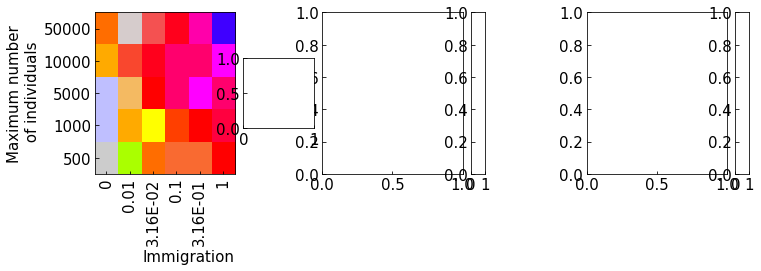

In [8]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    model = 'ibm'
    x = 'immigration'; y = 'sites';
    params = {'interaction' : 0.75, 'connectance' : 0.5} # 'sites' : 5000

    xticklabels = ['0', '$10^{-2}$', '', '$10^{-1}$', '', '$10^{0}$']

    #overview_figure(model, x, y, params, xticklabels)
    #plt.savefig('figures/immigration_sites_ibm.pdf')
    #figure_distribution_width(model, x, y, params, xticklabels)
    #plt.savefig('figures/immigration_sites_ibm_dist.pdf')
        
    overview_figure_slide(model, x, y, params, xticklabels)
    plt.savefig('../figures_presentation/ibm_dist.pdf')
    
    plt.show()
    

In [12]:
#ep = example_timeseries(connectance=0.8, immigration=0.01, int_strength=0.5, noise=None, 
# max_cap=None, sites=10000, S=200)

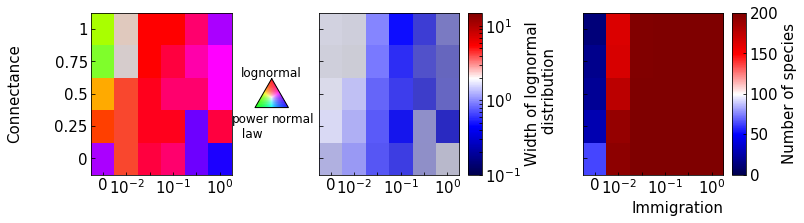

In [19]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    model = 'ibm'
    x = 'immigration'; y = 'connectance';
    params = {'interaction' : 0.75, 'sites' : 10000} #

    xticklabels = ['0', '$10^{-2}$', '', '$10^{-1}$', '', '$10^{0}$']

    #overview_figure(model, x, y, params, xticklabels)
    #plt.savefig('figures/immigration_connectance_ibm.pdf')
    #overview_figure2(model, x, y, params, xticklabels)
    #plt.savefig('figures/immigration_connectance_ibm_dist.pdf')
    #overview_figure_complete(model, x, y, params, xticklabels)
    #plt.savefig('figures/immigration_connectance_ibm_tot.pdf')
    
    overview_figure_slide(model, x, y, params, xticklabels)
    plt.savefig('../figures_presentation/ibm_dist.pdf')
    
    plt.show()

# GLV

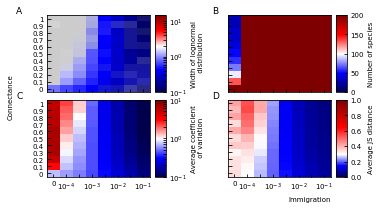

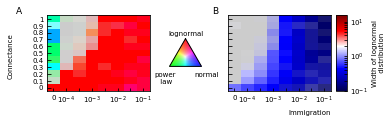

In [33]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    model = 'glv'
    x = 'immigration'; y = 'connectance';
    params = {'noise' : 0.5, 'interaction' : 0.5, 'max_cap' : 100} #

    xticklabels = ['0', '$10^{-4}$', '', '$10^{-3}$', '','$10^{-2}$', '', 
                   '$10^{-1}$', '', '$10^{0}$', '', '$10^{1}$']

    overview_figure(model, x, y, params, xticklabels)
    #plt.savefig('figures/connectance_immigration_glv.pdf')
    figure_distribution_width(model, x, y, params, xticklabels)
    #plt.savefig('figures/connectance_immigration_glv_dist.pdf')
    
    #params = {'noise' : 1e-7, 'interaction' : 0.5, 'max_cap' : 100} #
    #overview_figure(model, x, y, params, xticklabels, noise_implementation=NOISE.LANGEVIN_CONSTANT)
    #overview_figure2(model, x, y, params, xticklabels, noise_implementation=NOISE.LANGEVIN_CONSTANT)
    
    plt.show()

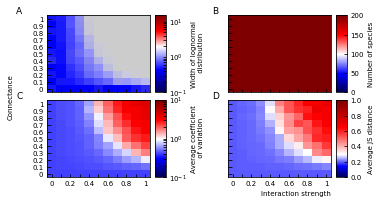

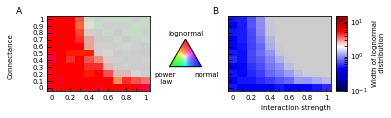

In [34]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    model = 'glv'
    x = 'interaction'; y = 'connectance';
    params = {'noise' : 0.5, 'immigration' : 0.1, 'max_cap' : 200} #

    xticklabels = ['0', '', '0.2', '', '0.4','', '0.6', 
                   '', '0.8', '', '1']

    overview_figure(model, x, y, params, xticklabels)
    #plt.savefig('figures/interactions_glv_100.pdf')
    figure_distribution_width(model, x, y, params, xticklabels)
    #plt.savefig('figures/interactions_glv_100_dist.pdf')
    
    #overview_figure(model, x, y, params, xticklabels, noise_implementation=NOISE.LANGEVIN_CONSTANT)
    #overview_figure2(model, x, y, params, xticklabels, noise_implementation=NOISE.LANGEVIN_CONSTANT)
    
    plt.show()

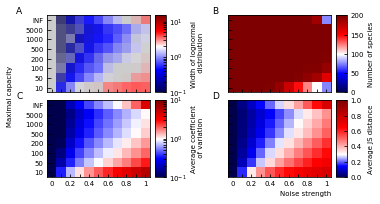

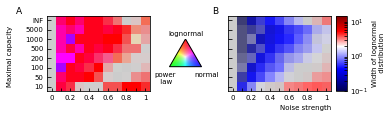

In [35]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    model = 'glv'
    x = 'noise'; y = 'max_cap';
    params = {'interaction' : 0., 'immigration' : 0., 'connectance' : 0.} #

    xticklabels = ['0', '', '0.2', '', '0.4','', '0.6', 
                   '', '0.8', '', '1']

    overview_figure(model, x, y, params, xticklabels)
    #plt.savefig('figures/maxcap_noise.pdf')
    figure_distribution_width(model, x, y, params, xticklabels)
    #plt.savefig('figures/maxcap_noise_dist.pdf')
    
    #overview_figure(model, x, y, params, noise_implementation=NOISE.LANGEVIN_CONSTANT)
    #overview_figure2(model, x, y, params, noise_implementation=NOISE.LANGEVIN_CONSTANT)
    
    plt.show()

In [36]:
#ep = example_timeseries(connectance=0.5, immigration=0., int_strength=0.5, noise=0.01, 
#                       max_cap=1000, sites=None, S=200,
#                        noise_implementation=NOISE.LANGEVIN_LINEAR)

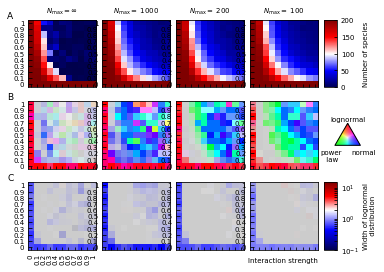

In [37]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    model = 'glv'
    x = 'interaction'; y = 'connectance';
    params = {'immigration' : 0., 'noise' : 0.5}
    figure_changing_maxcap(model, x, y, params, xticklabels='auto', yticklabels='auto', 
                        noise_implementation=NOISE.LANGEVIN_LINEAR)
    #plt.savefig('figures/changing_maxcap.pdf')
    
    #figure_changing_maxcap(model, x, y, params, xticklabels='auto', yticklabels='auto', 
    #                    noise_implementation=NOISE.LANGEVIN_CONSTANT)
    plt.show()

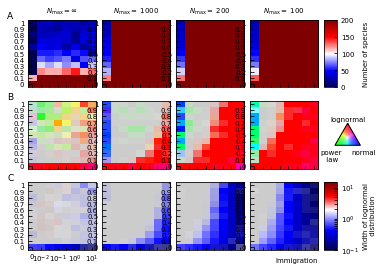

In [38]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    model = 'glv'
    x = 'immigration'; y = 'connectance';
    params = {'noise' : 0.5, 'interaction' : 0.5}
    
    xticklabels = ['0', '$10^{-2}$', '', '$10^{-1}$', '', '$10^{0}$', '', '$10^{1}$']
    
    figure_changing_maxcap(model, x, y, params, xticklabels=xticklabels, yticklabels='auto', 
                        noise_implementation=NOISE.LANGEVIN_LINEAR)
    #plt.savefig('figures/changing_maxcap2.pdf')
    
    #figure_changing_maxcap(model, x, y, params, xticklabels=xticklabels, yticklabels='auto', 
    #                    noise_implementation=NOISE.LANGEVIN_CONSTANT)
    plt.show()

<Figure size 396.85x108 with 0 Axes>

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


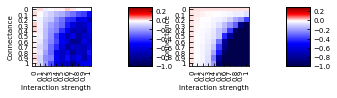

In [39]:
fig = plt.figure(figsize=(ELIFE.TEXTWIDTH, 1.5), tight_layout=True)

x = 'interaction'; y = 'connectance';
model = 'glv'

params = {'immigration' : 0.1, 'noise' : 0.5}

fig = plt.figure(figsize=(ELIFE.TEXTWIDTH, 1.5), tight_layout=True)
gs = gridspec.GridSpec(1,4,width_ratios=[5,1,5,1],wspace=0.1,top=0.85,bottom=0.3)

for ax, ax_cbar, var, dist in zip([fig.add_subplot(gs[0]), fig.add_subplot(gs[2])],
                         [fig.add_subplot(gs[1]), fig.add_subplot(gs[3])],
                         ['width', 'variation_mean'],
                         ['log', None]):
    params['max_cap'] = 100
    mat100 = comparison_matrix(x=x, y=y, var=var, dist=dist, model=model, 
                        agg=np.nanmedian, ax=ax, ax_cbar=ax_cbar, params=params)

    params['max_cap'] = 200
    mat200 = comparison_matrix(x=x, y=y, var=var, dist=dist, model=model, 
                            agg=np.nanmedian, ax=ax, ax_cbar=ax_cbar, params=params)

    mat_diff = mat100 - mat200
    
    im = ax.imshow(mat_diff, cmap='seismic', norm=PiecewiseNormalize([-1.0, 0.0, 0.3], [0, 0.5, 1]))
    plt.colorbar(im, cax=ax_cbar)

#plt.savefig('figures/changing_maxcap.pdf')
plt.show()

# Logistic results

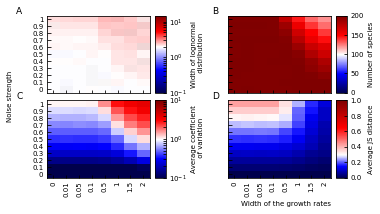

In [40]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    model = 'logistic'
    x = 'width_growth'; y = 'noise';
    params = {} #

    #xticklabels = ['$10^{-3}$', '', '',
    #                '$10^{-2}$', '', '', '$10^{-1}$', '', '', '2']
    #yticklabels = ['0', '$10^{-3}$', '', '', '',
    #                '$10^{-2}$', '', '', '', '$10^{-1}$', '', '', '', '1']
    xticklabels = 'auto' #None
    yticklabels = 'auto' #None
    
    overview_figure(model, x, y, params, xticklabels, yticklabels)
    #plt.savefig('figures/logistic.pdf')
    
    #overview_figure(model, x, y, params, xticklabels, noise_implementation=NOISE.LANGEVIN_CONSTANT)
    
    plt.show()

Deterministic solution is stable: True
variation: 0.09865569318780752
JS: 0.049296185919722235
pval stable (higher more stable): 0.013074791090735
remaining species 200
things 0.03849203672707368 0.044690596501008865 200 False
Width lognorm: 0.12470129528738962 0.0 1.0
Stat lognorm: 0.0664767854405337
Stat expon: 0.2928349643420225
Stat norm: 0.06833988141199387
Stat powerlaw: 0.34453356915456723


/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2407: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


Stat pareto: 0.3223005618527265
Stat trunc powerlaw: 0.38214284753935857
R powerlaw (negative -> lognormal): -101.8515156375476


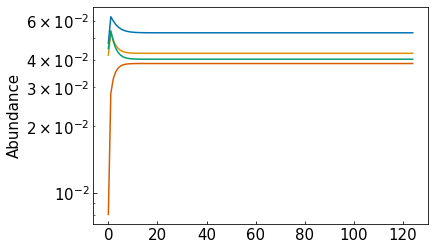

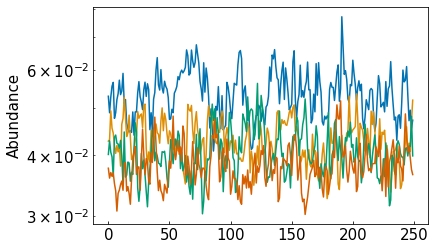

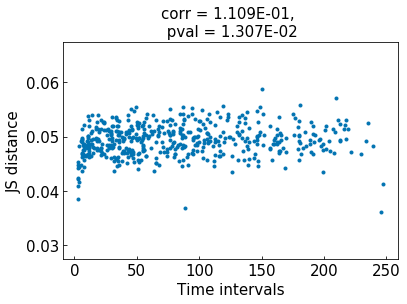

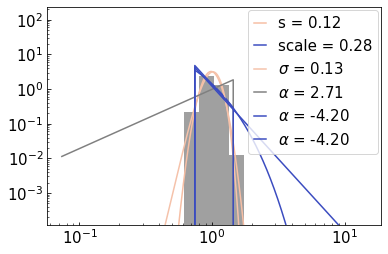

In [8]:
ts = example_timeseries(connectance=0.4, immigration=0.1, noise=0.1, 
                   int_strength=0.3, max_cap=10)

#example_timeseries_logistic(width_growth=1, noise=0.7, S=200)

# Time averaging 

Does taking the time average of the time series makes the abundance distribution less wide? 

It depends on the parameters (noise strength, interaction strength, maximum capacity).

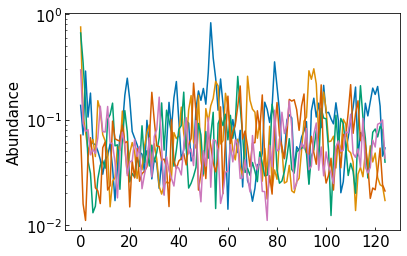

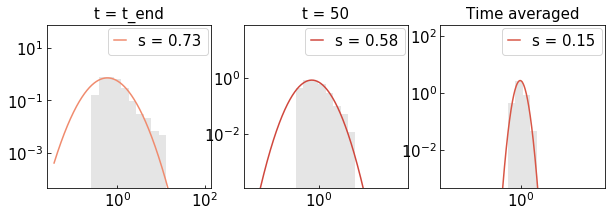

In [74]:
S = 50
migration = 0.3
int_strength = 0.8

params = random_parameter_set(
    S, connectance=0.3, minint=-int_strength, maxint=int_strength,
    minmigration=migration, maxmigration=migration,
    minextinction=0.5, maxextinction=0.5, growth_rate=1.5)

params['maximum_capacity'] = 4.0
params['initial_condition'] = np.random.uniform(0, 1, [S,1])
params['noise_linear'] = 0.8

ts = glv.Timeseries(params, T = 125, dt=0.005, tskip=199, model=MODEL.MAX)

PlotTimeseries(ts.timeseries)

fig = plt.figure(figsize=(10,3))

ax = fig.add_subplot(131)
ax.set_title('t = t_end')
ht_params = fit_heavytail(ts.endpoint.values, func='lognorm')
plot_heavytail(ts.endpoint.values, ht_params, func='lognorm', ax=ax)

ax = fig.add_subplot(132)
ax.set_title('t = 50')
ht_params = fit_heavytail(ts.timeseries.values[50,1:], func='lognorm')
plot_heavytail(ts.timeseries.values[50,1:], ht_params, func='lognorm', ax=ax)

ax = fig.add_subplot(133)
ax.set_title('Time averaged')
ht_params = fit_heavytail(ts.timeseries.iloc[20:,1:].mean(axis=0).values, func='lognorm')
plot_heavytail(ts.timeseries.iloc[20:,1:].mean(axis=0).values, ht_params, func='lognorm', ax=ax)

plt.show()



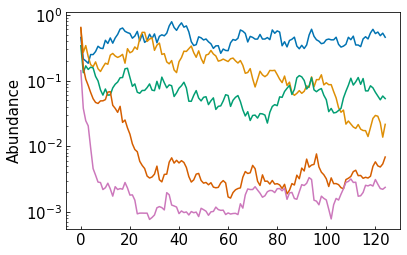

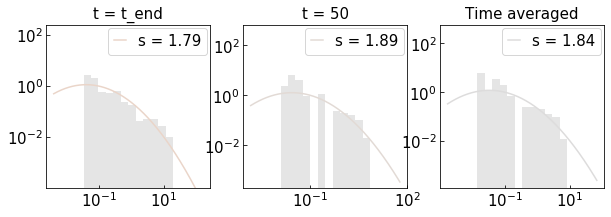

In [75]:
S = 50
migration = 0.001 # 0.01
int_strength = 0.8

params = random_parameter_set(
    S, connectance=0.3, minint=-int_strength, maxint=int_strength,
    minmigration=migration, maxmigration=migration,
    minextinction=0.5, maxextinction=0.5, growth_rate=1.5)

params['maximum_capacity'] = 10.0
params['initial_condition'] = np.random.uniform(0, 1, [S,1])
params['noise_linear'] = 0.2

ts = glv.Timeseries(params, T = 125, dt=0.005, tskip=199, model=MODEL.MAX)

PlotTimeseries(ts.timeseries)

fig = plt.figure(figsize=(10,3))

ax = fig.add_subplot(131)
ax.set_title('t = t_end')
ht_params = fit_heavytail(ts.endpoint.values, func='lognorm')
plot_heavytail(ts.endpoint.values, ht_params, func='lognorm', ax=ax)

ax = fig.add_subplot(132)
ax.set_title('t = 50')
ht_params = fit_heavytail(ts.timeseries.values[50,1:], func='lognorm')
plot_heavytail(ts.timeseries.values[50,1:], ht_params, func='lognorm', ax=ax)

ax = fig.add_subplot(133)
ax.set_title('Time averaged')
ht_params = fit_heavytail(ts.timeseries.iloc[20:,1:].mean(axis=0).values, func='lognorm')
plot_heavytail(ts.timeseries.iloc[20:,1:].mean(axis=0).values, ht_params, func='lognorm', ax=ax)

plt.show()